## Accessing ICESat-2 Data
### Data Query and Download Example Notebook
This notebook illustrates the use of icepyx for ICESat-2 data access and download from the NASA NSIDC DAAC (NASA National Snow and Ice Data Center Distributed Active Archive Center).

#### Credits
* notebook by: Jessica Scheick
* source material: [NSIDC Data Access Notebook](https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/tree/master/03_NSIDCDataAccess_Steiker) by Amy Steiker and Bruce Wallin


### Import packages, including icepyx

In [1]:
from icepyx import is2class as ipd
import os
import shutil
%matplotlib inline

In [2]:
!pwd

/home/jovyan/icepyx/doc/examples


### Quick-Start

The entire process of getting ICESat-2 data (from query to download) can ultimately be accomplished in three minimal lines of code:

`region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)`

`session=region_a.earthdata_login(earthdata_uid, email)`

`region_a.download_granules(session, path)`

**The rest of this notebook explains the required inputs used above, optional inputs not available in the minimal example, and the other data search and visualization tools built in to icepyx that make it easier for the user to find, explore, and download ICESat-2 data programmatically from NSIDC.** The detailed steps outlined and the methods showcased below are meant to give the user more control over the data they find and download (including options to download only the relevant portions of a data granule), many of which are called using default values behind the scenes if the user simply skips to the `download_granules` step.

### Create an ICESat-2 data object with the desired search parameters

There are three required inputs:
- `short_name` = the dataset of interest, known as its "short name".
See https://nsidc.org/data/icesat-2/data-sets for a list of the available datasets.
- `spatial extent` = a region of interest to search within. This can be entered as a bounding box, polygon vertex coordinate pairs, or a polygon geospatial file (currently shp, kml, and gpkg are supported).
    - bounding box: Given in decimal degrees for the lower left longitude, lower left latitude, upper right longitude, and upper right latitude
    - polygon vertices: Given as longitude, latitude coordinate pairs of decimal degrees with the last entry a repeat of the first.
    - polygon file: A string containing the full file path and name.
- `date_range` = the date range for which you would like to search for results. Must be formatted as a set of 'YYYY-MM-DD' strings.

Below are examples of each type of spatial extent input. Please choose and run only one.

In [9]:
#bounding box
short_name = 'ATL06'
spatial_extent = [-55, 68, -48, 71]
date_range = ['2019-02-22','2019-02-28']

In [14]:
#NOTE: currently a polygon generated using this block will not make it through the workflow.
#A bug report has been posted and work to correct the issue is ongoing.
#polygon vertices (here equivalent to the bounding box, above)
short_name = 'ATL06'
spatial_extent = [(-55, 68), (-55, 71), (-48, 71), (-48, 68), (-55, 68)]
date_range = ['2019-02-22','2019-02-28']

In [6]:
#polygon geospatial file
short_name = 'ATL06'
spatial_extent = './supporting_files/data-access_PineIsland/glims_polygons.kml'
date_range = ['2019-02-22','2019-02-28']

Create the data object using our inputs

In [16]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)

Formatted parameters and function calls allow us to see the the properties of the data object we have created.

ATL06
['2019-02-22', '2019-02-28']
00:00:00
23:59:59
002
['polygon', [[-55.0, -55.0, -48.0, -48.0, -55.0], [68.0, 71.0, 71.0, 68.0, 68.0]]]


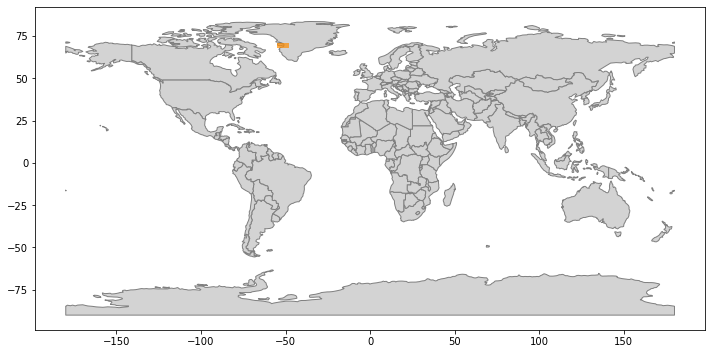

In [17]:
print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)
region_a.visualize_spatial_extent()

There are also several optional inputs to allow the user finer control over their search.
- `start_time` = start time to search for data on the start date. If no input is given, this defaults to 00:00:00.
- `end_time` = end time for the end date of the temporal search parameter. If no input is given, this defaults to 23:59:59. Times must be input as 'HH:mm:ss' strings.
- `version` = What version of the dataset to use, input as a numerical string. If no input is given, this value defaults to the most recent version of the dataset specified in `short_name`.

In [13]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range, \
                           start_time='03:30:00', end_time='21:30:00', version='001')

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-02-22', '2019-02-28']
03:30:00
21:30:00
001
['bounding box', [-55, 68, -48, 71]]


/home/jovyan/icepyx/icepyx/core/is2class.py:229: UserWarning: You are using an old version of this dataset
  warnings.warn("You are using an old version of this dataset")


Alternatively, you can also just create the data object without creating named variables first.

In [8]:
region_a = ipd.Icesat2Data('ATL06',[-55, 68, -48, 71],['2019-02-01','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59', version='002')

### Built in methods allow us to get more information about our dataset
In addition to viewing the stored object information shown above (e.g. dataset, start and end date and time, version, etc.), we can also request summary information about the dataset itself or confirm that we have manually specified the latest version.

In [6]:
region_a.dataset_summary_info()
print(region_a.latest_version())

dataset_id :  ATLAS/ICESat-2 L3A Land Ice Height V002
short_name :  ATL06
version_id :  002
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL06) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '94.29', 'inclination_angle': '92.0', 'number_of_orbits': '0.071428571', 'start_circular_latitude': '0.0'}
002


If the summary does not provide all of the information you are looking for, or you would like to see information for previous versions of the dataset, all available metadata for the collection dataset is available in a readable format.

In [7]:
region_a.dataset_all_info()

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

### Querying a dataset
In order to search the dataset collection for available data granules, we need to build our search parameters. These are formatted as a dictionary of key:value pairs according to the CMR documentation.

In [9]:
region_a.build_CMR_params()

In [7]:
#view the parameters that will be submitted in our query
region_a.CMRparams

{'short_name': 'ATL06',
 'version': '002',
 'temporal': '2019-02-22T00:00:00Z,2019-02-28T23:59:59Z',
 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.449791,-76.666392,-101.310795,-7

Now that our parameter dictionary is constructed, we can search the CMR database for the available granules. Granules returned by the search are automatically stored within the data object.

In [11]:
#search for available granules
region_a.avail_granules()

{'Number of available granules': 3,
 'Average size of granules (MB)': 46.62313429513333,
 'Total size of all granules (MB)': 139.8694028854}

In [20]:
#print the information about the returned search results
region_a.granules

[{'producer_granule_id': 'ATL06_20190224014644_08800205_001_02.h5',
  'time_start': '2019-02-24T01:46:44.000Z',
  'orbit': {'ascending_crossing': '118.48823342351116',
   'start_lat': '80',
   'start_direction': 'D',
   'end_lat': '59.5',
   'end_direction': 'D'},
  'updated': '2019-07-29T15:24:14.848Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-24T01:20:38.079Z',
    'equator_crossing_longitude': '118.48823342351116',
    'orbit_number': '2468'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL06.001:163362111',
  'coordinate_system': 'ORBIT',
  'time_end': '2019-02-24T01:52:09.000Z',
  'id': 'G1626612008-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '51.3712024689',
  'browse_flag': True,
  'polygons': [['80.11254119920325 -55.514517904891214 61.18421494056679 -65.31024196939337 59.5979414453054 -65.65802135334556 59.620288355717484 -66.29682109861751 61.20767873724507 -6

### Downloading the found granules
In order to download any data from NSIDC, we must first authenticate ourselves using a valid Earthdata login. This will create a valid token to interface with the DAAC as well as start an active logged-in session to enable data download. The token is attached to the data object and stored, but the session must be passed to the download function. Passwords are entered but not shown or stored in plain text by the system (I think?)

In [22]:
earthdata_uid = ''
email = ''
session=region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ········


Once we have generated our session, we must build the required configuration parameters needed to actually download data. These will tell the system how we want to download the data.
- `page_size` = 10. This is the number of granules we will request per order.
- `page_num` = 1. Determine the number of pages based on page size and the number of granules available. If no page_num is specified, this calculation is done automatically to set page_num, which then provides the number of individual orders we will request given the number of granules.
- `request_mode` = 'async'
- `agent` = 'NO'
- `include_meta` = 'Y'

#### More details about the configuration parameters
`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

**Use the streaming `request_mode` with caution: While it can be beneficial to stream outputs directly to your local directory, note that timeout errors can result depending on the size of the request, and your request will not be queued in the system if NSIDC is experiencing high request volume. For best performance, NSIDC recommends setting `page_size=1` to download individual outputs, which will eliminate extra time needed to zip outputs and will ensure faster processing times per request. An example streaming request loop is available at the bottom of the tutorial below.**

Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous (streaming). For now, let's select 10 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

If no keyword inputs are entered into the build function for these parameters, default values will be used. We must also specify that we would like to build the required configuration parameters for downloading (versus those needed for a 'search').

In [21]:
region_a.build_reqconfig_params('download', page_size=9)

In [22]:
region_a.reqparams

{'page_size': 9, 'page_num': 1, 'request_mode': 'async', 'include_meta': 'Y'}

#### Place the order
Then, we can send the order to NSIDC by providing our active session to the order_granules function. Information about the granules ordered and their status will be printed automatically as well as emailed to the address provided. Additional information on the order, including request URLs, can be viewed by setting the optional keyword input 'verbose' to True.

In [25]:
region_a.order_granules(session)
#region_a.order_granules(session, verbose=True)

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=002&temporal=2019-02-22T00%3A00%3A00Z%2C2019-02-28T23%3A59%3A59Z&bounding_box=-64%2C66%2C-55%2C72&page_size=9&page_num=1&email=jessica.scheick%40maine.edu&token=E175B383-E4B9-57E2-7F53-C901D287A528&request_mode=async&agent=NO&include_meta=Y
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:eesi="http://eosdis.nasa.gov/esi/rsp/e" xmlns:esi="http://eosdis.nasa.gov/esi/rsp" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n    <order>\n        <orderId>5000000416602</orderId>\n        <Instructions>You may receive an email about your order if you specifi

In [26]:
#view a short list of order IDs
region_a.orderIDs

['5000000416602']

#### Download the order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword 'verbose'.

In [35]:
path = './downloads'
region_a.download_granules(session, path)

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=002&temporal=2019-02-22T00%3A00%3A00Z%2C2019-02-28T23%3A59%3A59Z&bounding_box=-64%2C66%2C-55%2C72&email=jessica.scheick%40maine.edu&token=464C6E30-135C-0274-5E50-8DA341E5D482&page_size=10&page_num=1&request_mode=async&agent=NO&include_meta=Y
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:eesi="http://eosdis.nasa.gov/esi/rsp/e" xmlns:esi="http://eosdis.nasa.gov/esi/rsp" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n    <order>\n        <orderId>5000000415433</orderId>\n        <Instructions>You may receive an email about your order if you specif

#### Clean up the download folder by removing individual order folders:

In [31]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

## Elements to develop further/implement (and then include in the example, as in Amy's tutorial)
- cleaning up of download folder (default vs above code block as part of example)
- customization: subsetting and reformatting (check for options and include with order)
- more information/details on the above steps for a novice user